Importing necessary packages and libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


Data loading and data summary

Dataset Shape: (113932, 98)

Columns: ['listingkey', 'listingnumber', 'listingcreationdate', 'term', 'borrowerapr', 'prosperrating_numeric', 'prosperscore', 'listingcategory_numeric', 'borrowerstate', 'occupation', 'employmentstatusduration', 'isborrowerhomeowner', 'currentlyingroup', 'datecreditpulled', 'creditscorerangelower', 'creditscorerangeupper', 'firstrecordedcreditline', 'currentcreditlines', 'opencreditlines', 'totalcreditlinespast7years', 'openrevolvingaccounts', 'openrevolvingmonthlypayment', 'inquirieslast6months', 'totalinquiries', 'currentdelinquencies', 'amountdelinquent', 'delinquencieslast7years', 'publicrecordslast10years', 'publicrecordslast12months', 'revolvingcreditbalance', 'bankcardutilization', 'availablebankcardcredit', 'totaltrades', 'tradesneverdelinquent_percentage', 'tradesopenedlast6months', 'debttoincomeratio', 'incomeverifiable', 'statedmonthlyincome', 'loankey', 'loancurrentdaysdelinquent', 'loanmonthssinceorigination', 'loannumber', 'loanoriginalamoun

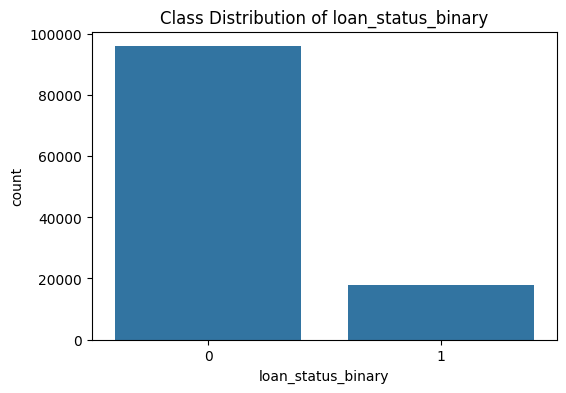

In [4]:
# Define dataset path (update for your environment)
DATA_PATH = r"C:\Users\karis\Financial-Risk-Pipeline-for-P2P-Lending-Investments\enhanced_featured_data.csv"


# Load dataset
df = pd.read_csv(DATA_PATH)

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing Values:\n", df.isnull().sum())
print("\nTarget Distribution:\n", df['loan_status_binary'].value_counts(normalize=True))

# Visualize class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status_binary', data=df)
plt.title('Class Distribution of loan_status_binary')
plt.show()

Data Preprocessing

In [5]:
# Drop irrelevant columns
df = df.drop(['listingkey'], axis=1, errors='ignore')

# Handle date columns (example: extract year and month)
date_cols = [col for col in df.columns if 'date' in col.lower()]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df = df.drop(col, axis=1)

# Handle missing values
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Drop high-cardinality columns
cardinality_threshold = 50
high_card_cols = [col for col in cat_cols if df[col].nunique() > cardinality_threshold]
df = df.drop(high_card_cols, axis=1)

# Encode categorical variables
le = LabelEncoder()
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Define features and target
X = df.drop('loan_status_binary', axis=1)
y = df['loan_status_binary']

# Check for data leakage
print("\nFeature-Target Correlations:\n", X.corrwith(y).sort_values(ascending=False).head(10))


Feature-Target Correlations:
 loancurrentdaysdelinquent          0.758738
delinquency_risk_score             0.745232
lp_grossprincipalloss              0.722012
lp_netprincipalloss                0.713108
loanmonthssinceorigination         0.376918
loan_age_months                    0.376815
lp_nonprincipalrecoverypayments    0.329244
employmentstatus_target_encoded    0.289395
inquirieslast6months               0.265734
totalinquiries                     0.253799
dtype: float64


Basic SVM model training and evaluation

✅ SVM Evaluation Metrics:
Accuracy:  0.99
Precision: 1.00
Recall:    0.94
F1-Score:  0.97
ROC AUC:   0.97
Initial SVM Accuracy: 0.9901989467524869

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     28778
           1       1.00      0.94      0.97      5402

    accuracy                           0.99     34180
   macro avg       0.99      0.97      0.98     34180
weighted avg       0.99      0.99      0.99     34180



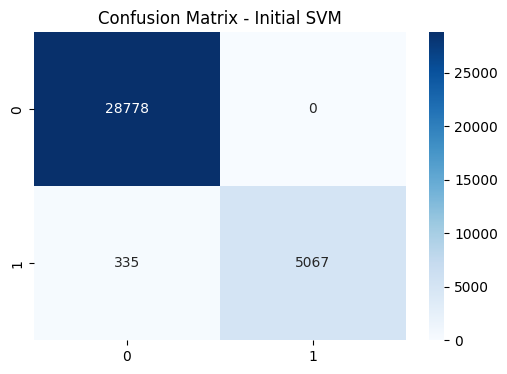

In [8]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm.predict(X_test_scaled)
# ===== Evaluation =====
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

print(f"✅ SVM Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"ROC AUC:   {roc_auc:.2f}")
# Evaluate
print("Initial SVM Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Initial SVM')
plt.show()

Cross validation (k-folds)

Cross-Validation Scores: [0.98933602 0.98942379 0.98916001 0.98973054 0.98880892]
Mean CV Accuracy: 0.9892918567557342
CV Standard Deviation: 0.0003041090513547161


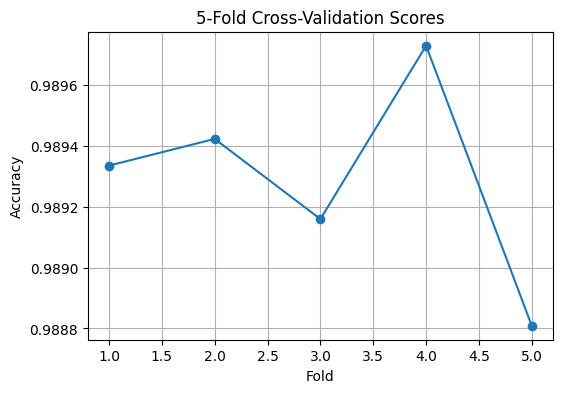

In [ ]:
# Cross-validation
cv_scores = cross_val_score(SVC(kernel='rbf', random_state=42), scaler.fit_transform(X), y, cv=5, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("CV Standard Deviation:", cv_scores.std())

# Visualize CV scores
plt.figure(figsize=(6, 4))
plt.plot(range(1, 6), cv_scores, marker='o')
plt.title('5-Fold Cross-Validation Scores')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

training balalnced class-weight SVM and evlaution

Balanced SVM Accuracy: 0.9933294324166179

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     28778
           1       0.99      0.97      0.98      5402

    accuracy                           0.99     34180
   macro avg       0.99      0.98      0.99     34180
weighted avg       0.99      0.99      0.99     34180



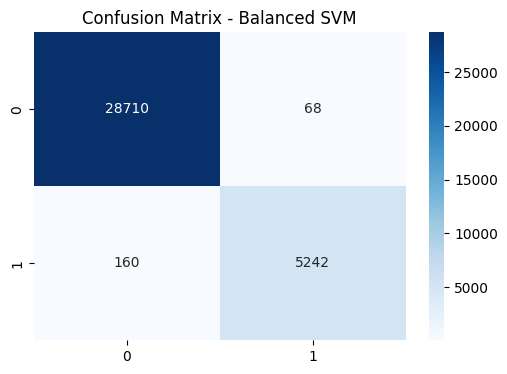

In [ ]:
# Train SVM with balanced class weights
svm_balanced = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_balanced.fit(X_train_scaled, y_train)

# Predictions
y_pred_balanced = svm_balanced.predict(X_test_scaled)

# Evaluate
print("Balanced SVM Accuracy:", accuracy_score(y_test, y_pred_balanced))
print("\nClassification Report:\n", classification_report(y_test, y_pred_balanced))
cm_balanced = confusion_matrix(y_test, y_pred_balanced)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Balanced SVM')
plt.show()

Trainign and evaluating SVM with synthetic data

SMOTE SVM Accuracy: 0.9945582211819778

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     28778
           1       1.00      0.97      0.98      5402

    accuracy                           0.99     34180
   macro avg       0.99      0.98      0.99     34180
weighted avg       0.99      0.99      0.99     34180



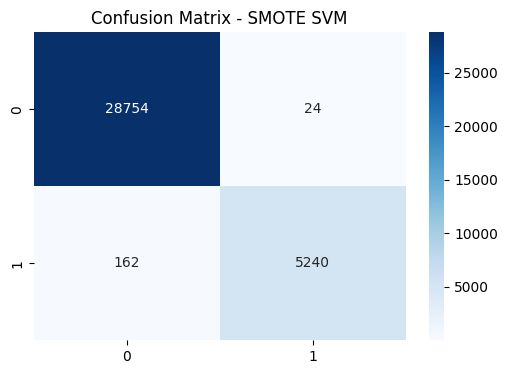

In [ ]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train SVM on SMOTE data
svm_smote = SVC(kernel='rbf', random_state=42)
svm_smote.fit(X_train_smote, y_train_smote)

# Predictions
y_pred_smote = svm_smote.predict(X_test_scaled)

# Evaluate
print("SMOTE SVM Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - SMOTE SVM')
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
import numpy as np
import pandas as pd

# ===== Initialize CV and model =====
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm = SVC(kernel='rbf', probability=True, random_state=42)

# ===== Store metrics =====
cv_metrics = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    # ===== Split =====
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # ===== Scale features =====
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ===== Apply SMOTE only to training set =====
    smote = SMOTE(random_state=42)
    X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

    # ===== Train =====
    svm.fit(X_train_res, y_train_res)

    # ===== Predict =====
    y_pred = svm.predict(X_test_scaled)
    y_proba = svm.predict_proba(X_test_scaled)[:, 1]

    # ===== Evaluate =====
    cv_metrics.append({
        'fold': fold + 1,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_proba),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    })

# ===== Summarize Results =====
cv_df = pd.DataFrame(cv_metrics)
print("🔹 Average Metrics Across 5 Folds:")
print(cv_df.drop(columns=['fold', 'confusion_matrix']).mean())

print("\n📊 Confusion Matrices Per Fold:")
for i, row in cv_df.iterrows():
    print(f"Fold {int(row['fold'])} Confusion Matrix:\n{row['confusion_matrix']}\n")


Parameter tuning ( note: machine is to weak to process this)






In [ ]:
'''# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

# Grid search
grid_search = GridSearchCV(SVC(kernel='rbf', random_state=42), param_grid, cv=3, scoring='f1_macro')
grid_search.fit(X_train_scaled, y_train)

# Best model
best_svm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (F1-Macro):", grid_search.best_score_)

# Evaluate on test set
y_pred_best = best_svm.predict(X_test_scaled)
print("Tuned SVM Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))'''

Lime explainer ( note: machine is to weak to process this)






In [ ]:
'''# Initialize LIME explainer
explainer = LimeTabularExplainer(
    X_train_scaled,
    feature_names=X.columns,
    class_names=['Non-Default', 'Default'],
    mode='classification'
)

# Explain a test instance
i = 0  # Example instance
exp = explainer.explain_instance(X_test_scaled[i], best_svm.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)'''

Hold-out Test set <br>
70% train, 15% validation, 15% test

Validation Accuracy: 0.9890598490610192

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     14392
           1       1.00      0.93      0.96      2701

    accuracy                           0.99     17093
   macro avg       0.99      0.97      0.98     17093
weighted avg       0.99      0.99      0.99     17093

Hold-Out Test Accuracy: 0.9905792861322411

Test Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     14389
           1       1.00      0.94      0.97      2701

    accuracy                           0.99     17090
   macro avg       0.99      0.97      0.98     17090
weighted avg       0.99      0.99      0.99     17090



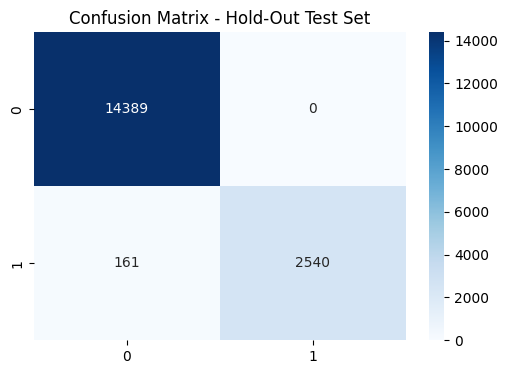

In [18]:
# Train-validation-test split
X_temp, X_test_holdout, y_temp, y_test_holdout = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)  # 0.1765 = 15/85

# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_holdout_scaled = scaler.transform(X_test_holdout)

# Train tuned SVM
svm_smote.fit(X_train_scaled, y_train)   #use "best_svm.fit(X_train_scaled, y_train)" --(if tunning cell is executed)


# Evaluate on validation set
y_val_pred = svm_smote.predict(X_val_scaled)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))

# Evaluate on test set
y_test_pred = svm_smote.predict(X_test_holdout_scaled)  #use "y_test_pred = best_svm.predict(X_test_holdout_scaled)" --(if tunning cell is executed)

print("Hold-Out Test Accuracy:", accuracy_score(y_test_holdout, y_test_pred))
print("\nTest Classification Report:\n", classification_report(y_test_holdout, y_test_pred))
cm_test = confusion_matrix(y_test_holdout, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Hold-Out Test Set')
plt.show()